In [1]:
import os
import importlib # since we are actively modifying the underlying modules it is very helpful 
                 # to be able to include changes without restarting the kernel with 
                 # importlib.reload( the_mod )

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import autoencoder as ae
import c10_reader as rdr

In [2]:
# Set random seed (for reproducibility)
seed = 1000
np.random.seed( seed )
tf.set_random_seed( seed )

TODO:
- Save the full model
- Load the model and pass in the placeholder?
- Clean up some of the visualization methods and make it easier to push the data into an eigenspace
- Better autoencoder architecture?
- Better loss functions? (not just L2 for recon...)
- Create new training loop based on the fixed codes
   - Make sure to save the ckpt in a recognizable way

In [3]:
HEIGHT = rdr.HEIGHT
WIDTH  = rdr.WIDTH
DEPTH  = rdr.DEPTH

TOT_CLASS_NUM = rdr.TOT_CLASS_NUM
TOT_TRAIN_EX  = rdr.TRAIN_EX
TOT_TEST_EX   = rdr.TEST_EX

In [4]:
code_dim =  32 # fixed for now
# code_dim = 128 # fixed for now

joint_epochs = 20
code_epochs  = 20

train_batch_size = 64
valid_batch_size = 64
test_batch_size  = 64
batch_size = tf.placeholder( tf.int64 )
is_train   = tf.placeholder( tf.bool )

train_on_full = False # True # train on our prebuilt, subset or the full set
train_classes = [ ii for ii in range( 8 ) ] # list of classes to train on
test_classes  = None # [ 3 ] # list of (additional) classes to test on (the out-of-distribution)
                      # None uses all classes

is_joint_class = not True
is_joint_ocnn  = not True
squish_classes = True

reg_flag = not True

nu = 0.1 # WAG
H  = code_dim / 2 # OC hidden layer size
# oc_nonlin = tf.nn.relu  # OC hidden activation
# oc_act = 'relu'
# oc_nonlin = tf.identity # OC hidden activation
# oc_act = 'idt'
oc_nonlin = tf.sigmoid
oc_act = 'sig'

class_num = TOT_CLASS_NUM

train_tfr_name = "./data/tfr/cifar-010/train.tfrecords"
valid_tfr_name = "./data/tfr/cifar-010/validate.tfrecords"
test_tfr_name  = "./data/tfr/cifar-010/test.tfrecords"

# if ( train_on_full ):
#     num_classes = 10
# else:
#     num_classes = 2
# print( "Building one-hot vectors with {} classes".format( num_classes ) )

In [5]:
if ( is_joint_class ):
    fol_name = 'yesClass_'
else: 
    fol_name = 'noClass_'

if ( is_joint_ocnn ):
    fol_name += 'yesOc'
else:
    fol_name += 'noOc'

In [6]:
data_path, train_name = os.path.split( train_tfr_name )
_,         valid_name = os.path.split( valid_tfr_name )
_,          test_name = os.path.split(  test_tfr_name )

os.makedirs( os.path.join( data_path, fol_name ), exist_ok=True )
train_code_tfr_name = os.path.join( data_path, fol_name, "code_{}_".format( code_dim ) + train_name )
valid_code_tfr_name = os.path.join( data_path, fol_name, "code_{}_".format( code_dim ) + valid_name )
test_code_tfr_name  = os.path.join( data_path, fol_name, "code_{}_".format( code_dim ) +  test_name )

In [7]:
all_classes = [ii for ii in range( TOT_CLASS_NUM )]

if ( squish_classes and train_on_full ):
    load_classes = all_classes
    sep_classes = [ii for ii in range( len( train_classes ) )]
    merge_classes = list( set( all_classes ) - set( train_classes ) )
    cl_name = 'squished'
    class_num = len( train_classes ) + 1
elif ( train_on_full ):
    load_classes = all_classes
    sep_classes = all_classes
    merge_classes = []
    cl_name = 'full'
    class_num = 10
else:
    load_classes = train_classes
    sep_classes = [ii for ii in range( len( train_classes ) )]
    merge_classes = []
    cl_name = 'expanded'
    class_num = len( train_classes ) + 1

This will erase any existing C10 TFR and replace them with the new data split

In [8]:
out_folder = "cifar-010/{}".format( fol_name ) 
out_file   = "{}_in{}_{}".format( 
    cl_name, ''.join( str( _ ) for _ in load_classes ), joint_epochs
)
if ( is_joint_ocnn ):
    if ( nu < 0.01 ) or ( nu > 1.0 ):
        print( "File name expects nu to be O(0.01)-O(1.0)")
    out_file = "p{}_".format( int( 100 * nu ) ) + out_file

ckpt_folder  = os.path.join( './ckpt_{}'.format( code_dim ), out_folder )
image_folder = os.path.join( './images', out_folder )

os.makedirs(  ckpt_folder, exist_ok=True )
os.makedirs( image_folder, exist_ok=True )

ckpt_fname = os.path.join( ckpt_folder, out_file + ".ckpt" )

print( "Checkpoint file set to: {}.".format( ckpt_fname ) ) # os.path.join( ckpt_folder, out_file ) ) )
print( "Image folder set to {}.".format( image_folder ) )

Checkpoint file set to: ./ckpt_32/cifar-010/noClass_noOc/expanded_in01234567_20.ckpt.
Image folder set to ./images/cifar-010/noClass_noOc.


In [9]:
def get_1class_dist( data, name='one_class_dist' ):
    with tf.variable_scope( name ):
        w_shape = [data.get_shape().as_list()[1],1];
        
        w = tf.random_normal( w_shape, mean=0, stddev=1, name='hyper_normal' )
        
    return tf.matmul( data, w ), w

def get_1class_loss( dist, r, nu, name='one_class' ):
    with tf.variable_scope( name ):
        
        main_loss = tf.reduce_mean( tf.nn.relu( r - dist ) ) / nu - r
        
    return main_loss

In [10]:
r = tf.Variable( 1.0, name='hyper_distance' )
# r = tf.constant( 10.0, dtype=tf.float32, name='hyper_distance' )

V = tf.get_variable( 
    'V', 
    [code_dim,H], 
    tf.float32, 
    tf.random_normal_initializer( stddev=0.01 )
)

V_norm = tf.norm( V, ord=2 ) / 2

Add additional losses (based on classification or 1-class SVM ideas)

In [11]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.0005, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * train_batch_size ) ) ), 
    decay_rate=0.95, 
    staircase=True
)

I want to be able to save checkpoints as I go

What I'll do, is create a tmp folder based on the name of the final ckpt file

I'll save intermediate ckpts to that file
When the final checkpoint has been saved, I'll delete the folder

TODO:
- Do I need to check that the model has been restored or is that guaranteed above?
- i.e. do I need to do the next cell in a session that has reloaded the checkpoint?

In [12]:
iterator, training_codeset, valid_codeset, testing_codeset = rdr.build_code_iterator( 
    train_code_tfr_name, 
    valid_code_tfr_name, 
    test_code_tfr_name, 
    code_dim, 
    class_num, 
    batch_size=batch_size, 
    train_batch_size=train_batch_size, 
    valid_batch_size=valid_batch_size, 
    test_batch_size=test_batch_size, 
    drop_remainder=True # this may not really be desirable...
)

training_init_op = iterator.make_initializer( training_codeset )
valid_init_op    = iterator.make_initializer( valid_codeset )
testing_init_op  = iterator.make_initializer( testing_codeset )

code, labels = iterator.get_next()

In [13]:
with tf.variable_scope( 'one_class' ):
    print( "Imposing a one-class SVM-like loss on the codes." )
    pre_one_class = oc_nonlin( tf.matmul( code, V ) )
    one_class_dist, oc_norm = get_1class_dist( pre_one_class )
    loss = get_1class_loss( one_class_dist, r, nu )
    
    if ( reg_flag ):
        loss += V_norm + tf.norm( oc_norm, ord=2 )
        reg_folder = "reg"
        print( "Imposing weight regularization loss.")
    else:
        reg_folder = "no_reg"

Imposing a one-class SVM-like loss on the codes.


In [14]:
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.0005, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * train_batch_size ) ) ), 
    decay_rate=0.99, 
    staircase=True
)

# train_op = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ).minimize( loss )
# train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( loss )
train_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( loss )

saver = tf.train.Saver()

ckpt_code_folder = os.path.join( ckpt_folder, reg_folder, "remainder_{}_p{}".format( oc_act, int( 10 * nu ) ) )
os.makedirs( ckpt_code_folder, exist_ok=True )
ckpt_code_fname = os.path.join( ckpt_code_folder, out_file+".ckpt" )
print( "Ckpt file set to {}.".format( ckpt_code_fname ) )

Ckpt file set to ./ckpt_32/cifar-010/noClass_noOc/no_reg/remainder_sig_p1/expanded_in01234567_20.ckpt.


In [15]:
with tf.Session() as sess:
    if not tf.train.checkpoint_exists( ckpt_code_fname ):
        # Train the model if it doesn't already exist
        print( 'Checkpoint not found.')
        
        print( 'Initializing global variables.' )
        sess.run(tf.global_variables_initializer())
        
        for ee in range( code_epochs ):
            print( 'Beginning epoch {} of {}.'.format( ee+1, code_epochs ) )
            
            cnt = 0
            train_loss = 0.0
            # Run some number of training batches in this epoch
            sess.run( training_init_op, feed_dict={batch_size: train_batch_size} )
            while True:
                try:
                    _, loss_, code_, labels_ = sess.run( [train_op, loss, code, labels], feed_dict={is_train: True} )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                train_loss += loss_
            
            train_loss = train_loss / cnt
            print( "  The average training loss at epoch {} was {} with {} steps.".format( ee+1, train_loss, cnt ) )
            
            cnt = 0
            test_loss = 0.0
            # Run some number of testing batches in this epoch
            sess.run( testing_init_op, feed_dict={batch_size: test_batch_size} )
            while True:
                try:
                    loss_ = sess.run( [loss], feed_dict={is_train: False} )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                test_loss += loss_[0]
            
            test_loss = test_loss / cnt
            print( "  The average testing loss at epoch {} was {} with {} steps".format( ee+1, test_loss, cnt ) )
        
        save_path = saver.save( sess, ckpt_code_fname )
        
    else:
        # Just load the model if we already have it
        print( "Loading parameter." )
        saver.restore( sess, ckpt_code_fname )
    
#     sess.run( training_init_code , feed_dict={batch_size: train_batch_size})
#     train_im, train_re, train_rl, train_lb0 = sess.run( 
#         [images, recon, recon_loss, labels], feed_dict={is_train: False} )
    
#     sess.run( testing_init_code, fseed_dict={batch_size: test_batch_size} )
#     test_im, test_re, test_lb0 = sess.run( [images, recon, labels], feed_dict={is_train: False})

Checkpoint not found.
Initializing global variables.
Beginning epoch 1 of 20.
  The average training loss at epoch 1 was 10.870381282269955 with 500 steps.
  The average testing loss at epoch 1 was 7.639704283995506 with 156 steps
Beginning epoch 2 of 20.
  The average training loss at epoch 2 was 6.399810765683651 with 500 steps.
  The average testing loss at epoch 2 was 4.957088044056525 with 156 steps
Beginning epoch 3 of 20.
  The average training loss at epoch 3 was 3.9051845997571943 with 500 steps.
  The average testing loss at epoch 3 was 2.681322726015097 with 156 steps
Beginning epoch 4 of 20.
  The average training loss at epoch 4 was 1.7416696563512086 with 500 steps.
  The average testing loss at epoch 4 was 0.6728481008456304 with 156 steps
Beginning epoch 5 of 20.
  The average training loss at epoch 5 was 0.19870949358772486 with 500 steps.
  The average testing loss at epoch 5 was 0.03208678756625606 with 156 steps
Beginning epoch 6 of 20.
  The average training loss a

In [16]:
if ( not is_joint_ocnn ):
    with tf.Session() as sess:
        saver.restore( sess, ckpt_code_fname )
        
        sess.run( training_init_op , feed_dict={batch_size: train_batch_size})
        
        r_all = []
        oc_dist_train = np.zeros( (0,1) )
        labels_train = np.zeros( (0,class_num) )
        while True:
            try:
                oc_dist_, lbls_, r_ = sess.run( [one_class_dist, labels, r], feed_dict={is_train: False} )
            except tf.errors.OutOfRangeError:
                break
            
            r_all.append( r_ )
            oc_dist_train = np.concatenate( ( oc_dist_train, oc_dist_ ), axis=0 )
            labels_train  = np.concatenate( ( labels_train,  lbls_ ), axis=0 )
            
        sess.run( testing_init_op , feed_dict={batch_size: train_batch_size})
        
        oc_dist_test = np.zeros( (0,1) )
        labels_test  = np.zeros( (0,class_num) )
        while True:
            try:
                oc_dist_, lbls_ = sess.run( [one_class_dist, labels], feed_dict={is_train: False} )
            except tf.errors.OutOfRangeError:
                break
            
            oc_dist_test = np.concatenate( ( oc_dist_test, oc_dist_ ), axis=0 )
            labels_test  = np.concatenate( ( labels_test,  lbls_ ), axis=0 )
            
oc_dist_train = np.squeeze( oc_dist_train )
oc_dist_test  = np.squeeze( oc_dist_test )

labels_train_num = np.argmax( labels_train, axis=1 )
labels_test_num  = np.argmax( labels_test,  axis=1 )

INFO:tensorflow:Restoring parameters from ./ckpt_32/cifar-010/noClass_noOc/no_reg/remainder_sig_p1/expanded_in01234567_20.ckpt


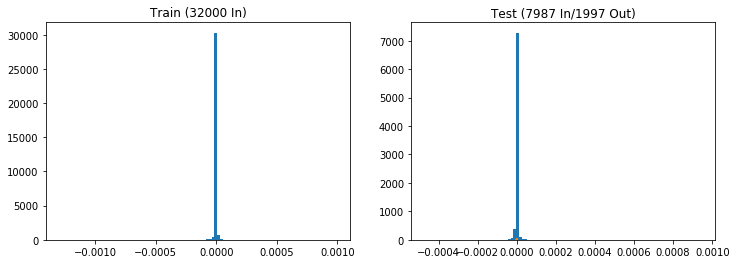

In [17]:
fig, ax = plt.subplots( 1 , 2, figsize=(12,4) )
_ = ax[0].hist( oc_dist_train, bins=100 )
_ = ax[0].set_title( 'Train ({} In)'.format( len( oc_dist_train ) ) )

in_test  = oc_dist_test[ labels_test_num != class_num-1 ]
out_test = oc_dist_test[ labels_test_num == class_num-1 ]
hist_ = ax[1].hist(  in_test, bins=100 )
_ = ax[1].hist( out_test, bins=100 )
_ = ax[1].set_title( 'Test ({} In/{} Out)'.format( len( in_test ), len( out_test ) ) )

fig.savefig( os.path.join( ckpt_code_folder, 'summary.png' ), dpi=216 )

The total training accuracy was: 45.47.
The total testing accuracy was: 48.05.


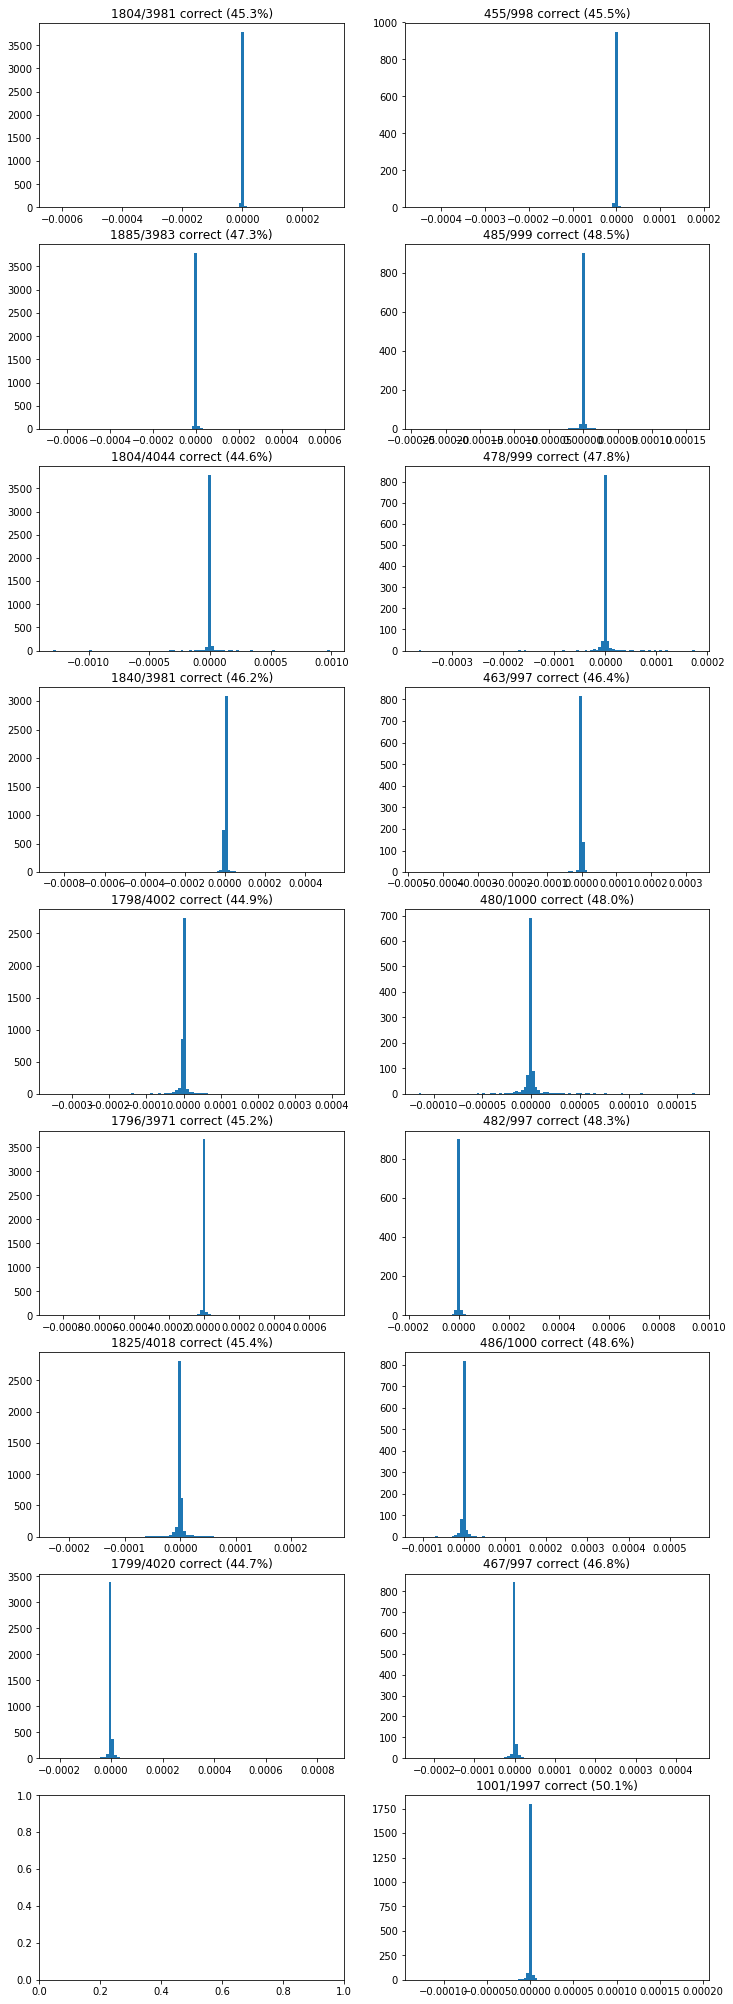

In [18]:
figc, axc = plt.subplots( class_num , 2, figsize=(12,4*class_num) )

corr_trn = 0
corr_tst = 0

# axc[cc,0].set_title( 'Train ({} In)'.format( len( oc_dist_train ) ) )
for cc in range( class_num-1 ):
    trn_class = oc_dist_train[np.argmax( labels_train, axis=1 ) == cc]
    tst_class = oc_dist_test[ np.argmax( labels_test,  axis=1 ) == cc]
    axc[cc,0].hist( trn_class, bins=100 )
    axc[cc,1].hist( tst_class, bins=100 )
    
    gtz = np.sum( trn_class >= 0 )
    corr_trn += gtz
    axc[cc,0].set_title( "{}/{} correct ({}%)".format( 
        gtz, len( trn_class ), float( 1000 * gtz // len( trn_class ) ) / 10 ) )
    
    gtz = np.sum( tst_class >= 0 )
    corr_tst += gtz
    axc[cc,1].set_title( "{}/{} correct ({}%)".format( 
        gtz, len( tst_class ), float( 1000 * gtz // len( tst_class ) ) / 10 ) )
    
#     axc[cc,0].set_xlim( [-1.5,1.5] )
#     axc[cc,1].set_xlim( [-1.5,1.5] )

out_test = oc_dist_test[ labels_test_num == class_num-1 ]
_ = axc[-1,1].hist( out_test, bins=100 )

ltz = np.sum( out_test < 0 )
axc[-1,1].set_title( "{}/{} correct ({}%)".format( 
    ltz, len( out_test ), float( 1000 * ltz // len( out_test ) ) / 10 ) )

corr_tst += ltz
# _ = axc[-1,1].set_xlim( [-1.5,1.5] )

train_acc = corr_trn / len( oc_dist_train )
test_acc  = corr_tst / len( oc_dist_test )

figc.savefig( os.path.join( ckpt_code_folder, "breakdown.png" ), dpi=216 )

train_text = "The total training accuracy was: {0:.2f}.".format( 100 * train_acc )
test_text  = "The total testing accuracy was: {0:.2f}.".format( 100 * test_acc )

sum_file = open( os.path.join( ckpt_code_folder, "summary.txt" ), 'w' )
sum_file.write( train_text + '\n' )
sum_file.write( test_text )
sum_file.close()

print( train_text )
print( test_text )